# Notebook imports

In [118]:
from os import walk
from os.path import join

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split 


# Constants

In [185]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SPAM_DATA_MINE/01-Processing/email-text-data.json'
WORD_ID_FILE = 'SPAM_DATA_MINE/01-Processing/word-by-id.csv'

TRAINING_DATA = 'SPAM_DATA_MINE/02-Training/train-data.txt'
TEST_DATA = 'SPAM_DATA_MINE/02-Training/test-data.txt'


# Reading Files 

In [4]:
stream = open(EXAMPLE_FILE)
message = stream.read()
stream.close()
print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [5]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [6]:
stream = open(EXAMPLE_FILE,encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    if line=='\n':
        is_body=True

stream.close()
email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Function

In [7]:
def generate_squares(N):
    for i in range(N):
        yield i**2

In [8]:
for i in generate_squares(5):
    print(i,end='->')

0->1->4->9->16->

# Email Body Extraction

In [9]:
def email_body_generator(path):
    
    for root,dirnames,filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root,file_name)
            stream = open(filepath,encoding='latin-1')
            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                if line=='\n':
                    is_body=True

            stream.close()
            email_body = '\n'.join(lines)

            yield file_name,email_body
    
    

In [10]:
def df_from_directory(path,classification):
    
    rows = []
    row_name = []
    for file_name,email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body,'CATEGORY':classification})
        row_name.append(file_name)
        
    return pd.DataFrame(rows,index=row_name)  

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH,SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))
spam_emails.head()

,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [12]:
# spam_emails.head()
spam_emails.shape

(1898, 2)

In [13]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
ham_emails.head()

,CATEGORY,MESSAGE
00001.7c53336b37003a9286aba55d2945844c,0,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
00002.9c4069e25e1ef370c078db7ee85ff9ac,0,"Martin A posted:\n\nTassos Papadopoulos, the G..."
00003.860e3c3cee1b42ead714c5c874fe25f7,0,Man Threatens Explosion In Moscow \n\n\n\nThur...
00004.864220c5b6930b209cc287c361c99af1,0,Klez: The Virus That Won't Die\n\n \n\nAlready...
00005.bf27cdeaf0b8c4647ecd61b1d09da613,0,"> in adding cream to spaghetti carbonara, whi..."


In [14]:
data = pd.concat([spam_emails,ham_emails])
# data.head()
# data.tail()
data.shape

(5799, 2)

# Data Cleaning: Checking for missing values

In [15]:
data['MESSAGE'].isnull().values.any()

False

In [16]:
(data.MESSAGE.str.len() == 0).sum()

3

In [17]:
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [21]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

#### Removing System file entries from Dataframe

In [22]:
data.shape

(5799, 2)

In [23]:
data.drop(['cmds'],inplace=True)

In [24]:
data.shape

(5796, 2)

## Add document ids to track emails in Dataset

In [25]:
data.head()

,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [29]:
doc_id = range(0,len(data.index))
doc_id

range(0, 5796)

In [30]:
doc_id[-1]

5795

In [31]:
data['DOC_ID'] = doc_id

In [32]:
data['filename'] = data.index

In [33]:
data.head()

,CATEGORY,MESSAGE,DOC_ID,filename
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",0,00001.7848dde101aa985090474a91ec93fcf0
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,2,00003.2ee33bc6eacdb11f38d052c44819ba6c
00004.eac8de8d759b7e74154f142194282724,1,##############################################...,3,00004.eac8de8d759b7e74154f142194282724
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...,4,00005.57696a39d7d84318ce497886896bf90d


In [34]:
data.index = data.DOC_ID

In [35]:
data.head()

,CATEGORY,MESSAGE,DOC_ID,filename
DOC_ID,,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",0,00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,2,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,3,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,4,00005.57696a39d7d84318ce497886896bf90d


In [36]:
data.drop(['DOC_ID'],axis=1,inplace=True)

In [37]:
data.head()

,CATEGORY,MESSAGE,filename
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


In [38]:
data.tail()

,CATEGORY,MESSAGE,filename
DOC_ID,,,
5791,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676
5794,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,0,"Hi there,\n\n\n\nNow this is probably of no us...",01400.f897f0931e461e7b2e964d28e927c35e


In [41]:
data.to_json(DATA_JSON_FILE) # Saving file as JSON using Pandas

## Data Visualization using Pie Chart


In [42]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [45]:
spam_amt = data.CATEGORY.value_counts()[1]
ham_amt = data.CATEGORY.value_counts()[0]

In [46]:
spam_amt

1896

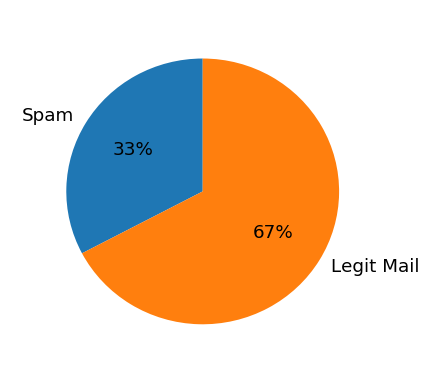

In [66]:
cat_names = ['Spam','Legit Mail']
size = [spam_amt,ham_amt]
plt.figure(figsize=(2,2),dpi=220)
plt.pie(size,labels=cat_names,textprops={'fontsize':6},startangle=90,autopct='%1.0f%%')
plt.show()

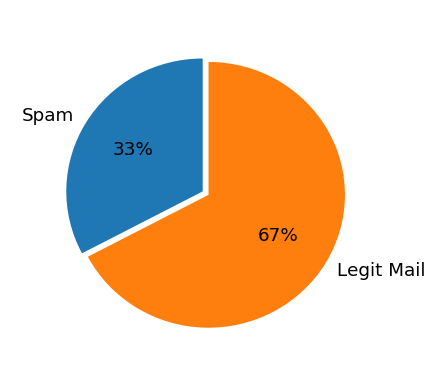

In [71]:
cat_names = ['Spam','Legit Mail']
size = [spam_amt,ham_amt]
plt.figure(figsize=(2,2),dpi=220)
plt.pie(size,labels=cat_names,textprops={'fontsize':6},startangle=90,autopct='%1.0f%%',explode=[0,0.05])
plt.show()

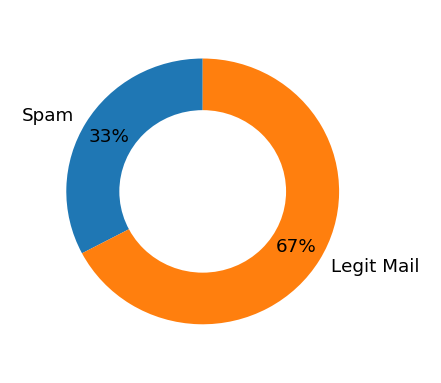

In [81]:
cat_names = ['Spam','Legit Mail']
size = [spam_amt,ham_amt]
plt.figure(figsize=(2,2),dpi=220)
plt.pie(size,labels=cat_names,textprops={'fontsize':6},startangle=90,autopct='%1.0f%%',pctdistance=0.8)

#draw circle
centre_c = plt.Circle((0,0),radius=0.6,color='white')
plt.gca().add_artist(centre_c)
plt.show()

## Natural Language Processing

Text Preprocessing

In [82]:
msg = "ALL dog Lover Are GooD PErSON"

In [89]:
msg.lower()

'all dog lover are good person'

In [91]:
import nltk

In [92]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sgupta427\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [93]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sgupta427\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [94]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\sgupta427\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\sgupta427\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\shakespeare.zip.


True

## Tokenizing

In [102]:
msg = 'Have you heard ? about that accident, oh god that was so heaRTbreaking that i couldn\'t even see !'

In [104]:
words = word_tokenize(msg.lower())

## Removing Stop words

In [98]:
stop_WORDS = set(stopwords.words('english'))

In [99]:
stop_WORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [101]:
if 'are' in stop_WORDS: print("There")

There


In [105]:
filtered_words = []
for word in words:
    if word not in stop_WORDS:
        filtered_words.append(word)
        

In [106]:
filtered_words

['heard',
 '?',
 'accident',
 ',',
 'oh',
 'god',
 'heartbreaking',
 'could',
 "n't",
 'even',
 'see',
 '!']

## Word stems and stemming

In [107]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

In [108]:
filtered_words = []
for word in words:
    if word not in stop_WORDS:
        stem_word = stemmer.stem(word)
        filtered_words.append(stem_word)

In [109]:
filtered_words

['work',
 'play',
 'make',
 'jack',
 'dull',
 'boy',
 '.',
 '.',
 'nobodi',
 'expect',
 'spanish',
 'inquisit',
 '!']

### Removing Punctuations

In [112]:
'a'.isalpha()

True

In [113]:
'/'.isalpha()

False

In [116]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer=SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_WORDS and word.isalpha():
        stem_word = stemmer.stem(word)
        filtered_words.append(stem_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML Tags

In [119]:
soup = BeautifulSoup(data.at[2,'MESSAGE'],'html.parser')


In [123]:
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [125]:
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [126]:
def clean_msg_no_html(message,stemmer=PorterStemmer(),stop_words = set(stopwords.words('english'))):
    
    # Remove html tags first
    soup = BeautifulSoup(message,'html.parser')
    clean_msg = soup.getText()
    
    #convert to lower and tokenize
    words = word_tokenize(clean_msg.lower())
    
    filtered_words = []
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [127]:
clean_msg_no_html(data.at[2,'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

## Applying Cleaning and tokenizing to all messages

In [128]:
data.iat[2,2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [129]:
data.head()

,CATEGORY,MESSAGE,filename
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


In [130]:
first_emails = data.MESSAGE.iloc[0:4]

In [131]:
first_emails

DOC_ID
0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
1    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
2    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
3    ##############################################...
Name: MESSAGE, dtype: object

In [132]:
nest_list = first_emails.apply(clean_msg_no_html)

In [133]:
nest_list

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
Name: MESSAGE, dtype: object

In [135]:
nest_list.shape

(4,)

In [140]:
nest_list

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
Name: MESSAGE, dtype: object

In [143]:
# Applying to all MESSAGES
%time
nested_list = data.MESSAGE.apply(clean_msg_no_html)

Wall time: 0 ns


C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [145]:
nested_list.shape

(5796,)

In [146]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [148]:
data[data.CATEGORY == 1].tail()

,CATEGORY,MESSAGE,filename
DOC_ID,,,
1891,1,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",01396.e80a10644810bc2ae3c1b58c5fd38dfa
1892,1,This is a multi-part message in MIME format.\n...,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1893,1,"Dear Subscriber,\n\n\n\nIf I could show you a ...",01398.8ca7045aae4184d56e8509dc5ad6d979
1894,1,****Mid-Summer Customer Appreciation SALE!****...,01399.2319643317e2c5193d574e40a71809c2
1895,1,ATTN:SIR/MADAN \n\n\n\n ...,01400.b444b69845db2fa0a4693ca04e6ac5c5


In [149]:
doc_id_spam = data[data.CATEGORY == 1].index
doc_id_ham = data[data.CATEGORY == 0].index

In [150]:
doc_id_spam.shape

(1896,)

In [152]:
doc_id_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [153]:
type(doc_id_spam)

pandas.core.indexes.numeric.Int64Index

In [154]:
type(nested_list)

pandas.core.series.Series

In [155]:
nested_list_ham = nested_list.loc[doc_id_ham]

In [156]:
nested_list_ham.shape

(3900,)

In [157]:
nested_list_spam = nested_list.loc[doc_id_spam]

In [158]:
nested_list_spam.tail()

DOC_ID
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, dtype: object

In [159]:
nested_list_spam.shape

(1896,)

In [160]:
nested_list_ham.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [161]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]

In [166]:
normal_words = pd.Series(flat_list_ham).value_counts()

In [167]:
normal_words.shape

(20751,)

In [168]:
normal_words[0:5]

http    7561
use     3630
list    2878
one     2371
get     2284
dtype: int64

In [169]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words.shape

(13282,)

In [170]:
spammy_words[:6]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
dtype: int64

## Generate Vocabulary and Dictionary

In [171]:
stemmed_nest_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stem_list = [item for sublist in stemmed_nest_list for item in sublist]

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [172]:
unique_words = pd.Series(flat_stem_list).value_counts()

In [173]:
unique_words.head()

http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [174]:
unique_words.shape

(27302,)

In [175]:
VOCAB_SIZE

2500

In [176]:
freq_word = unique_words[0:VOCAB_SIZE]

In [178]:
freq_word[:10]

http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64

In [179]:
freq_word.tail()

ximian     44
ratak      44
leas       44
tobacco    44
angel      44
dtype: int64

## Create Vocabulary Dataframe with word_ID

In [180]:
freq_word.index

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'mutual', 'asian', 'render', 'layer', 'contest', 'ximian', 'ratak',
       'leas', 'tobacco', 'angel'],
      dtype='object', length=2500)

In [181]:
word_id = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': freq_word.index.values},index=word_id)


In [183]:
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


In [186]:
vocab.to_csv(WORD_ID_FILE) # Saving file to CSV

In [187]:
'use' in set(vocab.VOCAB_WORD)

True

# Email with most number of words

In [190]:
clean_email_len = [len(s) for s in stemmed_nest_list]

In [193]:
type(clean_email_len)

list

In [194]:
max(clean_email_len)

7665

In [195]:
np.argmax(clean_email_len)

5775

In [197]:
stemmed_nest_list[np.argmax(clean_email_len)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [198]:
data.at[np.argmax(clean_email_len),'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

## Generating Feature and Sparse Matrix

In [199]:
type(stemmed_nest_list)

pandas.core.series.Series

In [200]:
stemmed_nest_list.tolist()

[['save',
  'life',
  'insur',
  'spend',
  'life',
  'quot',
  'save',
  'g',
  'famili',
  'financi',
  'secur',
  'import',
  'life',
  'quot',
  'save',
  'ke',
  'buy',
  'life',
  'insur',
  'simpl',
  'afford',
  'provid',
  'free',
  'access',
  'best',
  'compani',
  'lowest',
  'rate',
  'life',
  'quot',
  'save',
  'fast',
  'save',
  'money',
  'let',
  'us',
  'help',
  'get',
  'start',
  'best',
  'ue',
  'countri',
  'new',
  'coverag',
  'save',
  'hundr',
  'even',
  'usand',
  'dollar',
  'request',
  'free',
  'quot',
  'lifequot',
  'save',
  'servic',
  'take',
  'less',
  'minut',
  'complet',
  'shop',
  'compar',
  'save',
  'type',
  'life',
  'insur',
  'click',
  'free',
  'quot',
  'protect',
  'famili',
  'best',
  'invest',
  'r',
  'make',
  'receipt',
  'email',
  'error',
  'wish',
  'remov',
  'list',
  'pleas',
  'click',
  'type',
  'remov',
  'resid',
  'state',
  'prohibit',
  'solicit',
  'ce',
  'pleas',
  'disregard',
  'email'],
 ['fight',
  

In [201]:
type(stemmed_nest_list)

pandas.core.series.Series

In [203]:
words_col_df = pd.DataFrame.from_records(stemmed_nest_list.tolist())
words_col_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7655,7656,7657,7658,7659,7660,7661,7662,7663,7664
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [204]:
words_col_df.shape

(5796, 7665)

## Splitting Data into training and Test

In [205]:
X_train,X_test,y_train,y_test = train_test_split(words_col_df,data.CATEGORY,test_size=0.3,random_state=42)

In [206]:
X_train.shape

(4057, 7665)

In [207]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7655,7656,7657,7658,7659,7660,7661,7662,7663,7664
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [209]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7655,7656,7657,7658,7659,7660,7661,7662,7663,7664
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [210]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

In [211]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [214]:
word_index.get_loc('email')

3

In [215]:
word_index

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'mutual', 'asian', 'render', 'layer', 'contest', 'ximian', 'ratak',
       'leas', 'tobacco', 'angel'],
      dtype='object', name='VOCAB_WORD', length=2500)

In [216]:
def make_sparse_matrix(df,indexed_words,labels):
    
    rows = df.shape[0]
    cols = df.shape[1]
    
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(rows):
        for j in range(cols):
            
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL':category,'DOC_ID':doc_id,'OCCURENCE':1,'WORD_ID':word_id}
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)
                
    
    

In [219]:
%%time
sparse_train_df = make_sparse_matrix(X_train,word_index,y_train)

Wall time: 11min


In [220]:
sparse_train_df.head()

,DOC_ID,LABEL,OCCURENCE,WORD_ID
0,4844,0,1,265
1,4844,0,1,1267
2,4844,0,1,506
3,4844,0,1,310
4,4844,0,1,255


In [221]:
sparse_train_df.shape

(430919, 4)

In [222]:
train_group = sparse_train_df.groupby(['DOC_ID','LABEL','WORD_ID']).sum()
train_group.head()

OCCURENCE
DOC_ID LABEL WORD_ID           
0      1     2                1
             3                2
             4                1
             7                3
             11               1

In [223]:
train_group.shape

(258322, 1)

In [224]:
train_group = train_group.reset_index()
train_group.head()

,DOC_ID,LABEL,WORD_ID,OCCURENCE
0,0,1,2,1
1,0,1,3,2
2,0,1,4,1
3,0,1,7,3
4,0,1,11,1


In [226]:
train_group.shape

(258322, 4)

## Saving training data as text file

In [227]:
np.savetxt(TRAINING_DATA,train_group,fmt='%d')

In [228]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7655,7656,7657,7658,7659,7660,7661,7662,7663,7664
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [229]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [230]:
sparse_test_df = make_sparse_matrix(X_test,word_index,y_test)

In [231]:
sparse_test_df.shape

(203150, 4)

In [232]:
sparse_test_df.head()

,DOC_ID,LABEL,OCCURENCE,WORD_ID
0,4675,0,1,88
1,4675,0,1,301
2,4675,0,1,552
3,4675,0,1,85
4,4675,0,1,476


In [237]:
test_group = sparse_test_df.groupby(['DOC_ID','LABEL','WORD_ID']).sum().reset_index()

In [238]:
test_group.shape

(117618, 4)

In [239]:
np.savetxt(TEST_DATA,test_group,fmt='%d')